In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import skbio
import os
import qiime2
%matplotlib inline

from qiime2.plugins.diversity.actions import filter_distance_matrix, pcoa as pcoa_action
from qiime2.plugins.longitudinal.actions import first_distances, first_differences


In [2]:
base_dir = "/Users/gregcaporaso/Dropbox/shared-analysis-results/2019.09-exmp/combined/"
#sample_md_fp = os.path.join(base_dir, "sample-metadata", "sample-metadata.tsv")
sample_md_fp = os.path.join(base_dir, "dada2-paired-long", "sample-metadata-grouped-by-period.tsv")
data_dir = os.path.join(base_dir, "dada2-paired-long/cm15000-grouped-by-period")
output_dir = os.path.join(data_dir, "longitudinal-boxplots-grouped-by-period")

time_column = 'period'

uu = ("unweighted UniFrac", os.path.join(data_dir, "unweighted_unifrac_distance_matrix.qza"))
ai = ("Aitchison", os.path.join(data_dir, "aitchison_distance_matrix.qza"))
wu = ("weighted UniFrac", os.path.join(data_dir, "weighted_unifrac_distance_matrix.qza"))
bc = ("Bray-Curtis", os.path.join(data_dir, "bray_curtis_distance_matrix.qza"))
bj = ("Jaccard", os.path.join(data_dir, "jaccard_distance_matrix.qza"))
faithpd = ("Faith PD", os.path.join(data_dir, "faith_pd_vector.qza"))
observed_otus = ("Observed Features", os.path.join(data_dir, "observed_otus_vector.qza"))

In [3]:
sample_md = qiime2.Metadata.load(sample_md_fp)

In [4]:
baseline = 1
reference_week = 1
project = 'exmp2'
where = "[project]='%s' and [exclude]='no'" % project
ids_to_keep = sample_md.get_ids(where=where)
sample_md = sample_md.filter_ids(ids_to_keep=ids_to_keep)

metadata_to_merge = []
distance_columns = []
pcoa_columns = []
alpha_columns = []

In [5]:

for metric, dm_fp in [uu, ai, wu, bc, bj]:
    dm = qiime2.Artifact.load(dm_fp)
    dm = filter_distance_matrix(dm, metadata=sample_md).filtered_distance_matrix
    # add distances to baseline to sample metadata
    dists_to_baselines = first_distances(distance_matrix=dm, metadata=sample_md, state_column=time_column, 
                                         individual_id_column='subject-id', baseline=baseline, 
                                         replicate_handling='random').first_distances
    dists_to_baselines = dists_to_baselines.view(qiime2.Metadata).get_column('Distance').to_dataframe()
    column_name = '%s distance to %s %d' % (metric, time_column, baseline)
    dists_to_baselines = dists_to_baselines.rename(columns = {'Distance' : column_name})
    metadata_to_merge.append(qiime2.Metadata(dists_to_baselines))
    distance_columns.append(column_name)
    
    # add first three PCoA axes to sample metadata
    pcoa = pcoa_action(dm).pcoa
    pcoa = pcoa.view(qiime2.Metadata).to_dataframe()[['Axis 1', 'Axis 2', 'Axis 3']]
    column_names = {'Axis 1' : '%s PCoA 1' % metric, 
                    'Axis 2' : '%s PCoA 2' % metric,
                    'Axis 3' : '%s PCoA 3' % metric}
    pcoa = pcoa.rename(columns = column_names)

    metadata_to_merge.append(qiime2.Metadata(pcoa))
    pcoa_columns.extend(column_names.values())

/Users/gregcaporaso/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.020103852905319738 and the largest is 2.830431715584768.
  RuntimeWarning
/Users/gregcaporaso/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. 

In [6]:
for metric, alpha_vector_fp in [faithpd, observed_otus]:
    alpha_vector = qiime2.Artifact.load(alpha_vector_fp)
    alpha_vector_name = alpha_vector.view(pd.Series).name
    sample_md = sample_md.merge(alpha_vector.view(qiime2.Metadata))
    diffs_to_baselines = first_differences(metadata=sample_md, 
                                           state_column=time_column, metric=alpha_vector_name,                  
                                           individual_id_column='subject-id', baseline=baseline, 
                                           replicate_handling='random').first_differences
    diffs_to_baselines = diffs_to_baselines.view(qiime2.Metadata).get_column('Difference').to_dataframe()
    column_name = '%s difference from %s %d' % (metric, time_column, baseline)
    diffs_to_baselines = diffs_to_baselines.rename(columns = {'Difference' : column_name})
    metadata_to_merge.append(qiime2.Metadata(diffs_to_baselines))
    alpha_columns.append(column_name)

In [7]:
for e in metadata_to_merge:
    sample_md = sample_md.merge(e)
data = sample_md.to_dataframe()

In [8]:
data

,period,subject-id,project,activity,exclude,faith_pd,observed_otus,unweighted UniFrac distance to period 1,unweighted UniFrac PCoA 1,unweighted UniFrac PCoA 2,...,Bray-Curtis distance to period 1,Bray-Curtis PCoA 1,Bray-Curtis PCoA 2,Bray-Curtis PCoA 3,Jaccard distance to period 1,Jaccard PCoA 1,Jaccard PCoA 2,Jaccard PCoA 3,Faith PD difference from period 1,Observed Features difference from period 1
id,,,,,,,,,,,,,,,,,,,,,
3622f-2,2,3622f,exmp2,intervention,no,12.582849,110.0,0.435595,-0.227088,-0.042644,...,0.269667,0.056726,-0.348233,0.239193,0.473684,-0.312346,0.189226,-0.029563,-8.184263,-70.0
f5092-2,2,f5092,exmp2,intervention,no,29.996951,230.0,0.427724,-0.007808,0.339101,...,0.272467,0.040983,-0.142877,0.202710,0.479730,-0.199911,0.175325,0.379424,2.046176,10.0
007b6-2,2,007b6,exmp2,intervention,no,24.781073,239.0,0.277961,0.243206,-0.077651,...,0.360400,0.138397,0.135298,-0.053009,0.383901,0.145723,0.030920,-0.095757,-6.102479,-44.0
0fc81-2,2,0fc81,exmp2,intervention,no,9.907236,74.0,0.340309,-0.239713,-0.106587,...,0.596333,-0.067996,0.025616,-0.017088,0.459016,-0.152734,-0.110825,-0.124430,-1.690151,-40.0
113f1-2,2,113f1,exmp2,intervention,no,18.265800,166.0,0.342964,0.032593,-0.035604,...,0.350200,0.155996,0.002787,-0.095799,0.435644,0.122259,-0.155394,0.029069,1.316866,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e5b0a-5,5,e5b0a,exmp2,washout,no,19.507120,194.0,0.360544,0.128003,-0.099785,...,0.369733,0.091160,0.025188,0.032352,0.455782,0.128335,-0.040423,-0.096578,-5.527210,-66.0
fad9f-5,5,fad9f,exmp2,washout,no,15.639454,169.0,0.228512,-0.059109,-0.065131,...,0.350667,0.220712,0.002396,-0.177575,0.359116,0.032010,-0.162551,-0.014081,2.213263,41.0
113f1-5,5,113f1,exmp2,washout,no,13.576282,124.0,0.319536,-0.159366,0.033851,...,0.563933,0.156597,0.050865,-0.059097,0.443182,0.011042,-0.211109,0.077484,-3.372652,-26.0


In [9]:
data.to_csv('junk.csv')

In [10]:
import seaborn as sns
import scipy.stats
import bisect
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skbio.stats.distance import MissingIDError
from statsmodels.stats.multitest import multipletests

import matplotlib


alphas = [(0.001, '***'), (0.01, '**'), (0.05, '*')]

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 8}
matplotlib.rc('font', **font)

sns.set_style("whitegrid")

def get_sig_text(p, alphas, null_text=""):
    if np.isnan(p):
        return null_text
    alphas.sort()
    if p >= alphas[-1][0]:
        return 'ns'
    sorted_location = bisect.bisect([e[0] for e in alphas], p)
    return alphas[sorted_location][1]

def plot_week_data(df, metric, time_column, label_axes=True):
    df[time_column] = pd.to_numeric(df[time_column], errors='coerce')
    df[metric] = pd.to_numeric(df[metric], errors='coerce')
    
    df = df.sort_values(by=time_column)
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    ax = sns.boxplot(data=df, x=time_column, y=metric, color='white', ax=ax)
    ax = sns.swarmplot(data=df, x=time_column, y=metric, color='black', ax=ax)

    x0 = np.min(df[time_column]) - 1
    x1 = np.max(df[time_column]) + 1
    
    if not label_axes:
        ax.set_xlabel('')
        ax.set_ylabel('')
    return fig

# Change in distance to donor from time zero is different than zero
# (positive t means more different than donor, negative t means more similar to donor)
def tabulate_week_to_reference_week_paired_stats(df, metric, reference_time, time_column, test_fn=scipy.stats.mannwhitneyu):
    results = []
    df[time_column] = pd.to_numeric(df[time_column], errors='coerce')
    df = df.sort_values(by=time_column)
    weeks = df[time_column].unique()
    for i in weeks:
        reference_time_metric = df[df[time_column] == reference_time][metric]
        time_i_metric = df[df[time_column] == i][metric]
        t, p = test_fn(reference_time_metric, time_i_metric)
        results.append((i, len(time_i_metric), np.median(time_i_metric), t, p))
    result = pd.DataFrame(results,
                          columns=[time_column, 'n', metric, 'test-statistic', 'p-value']
                         )
    result = result.set_index(time_column)
    result['q-value'] = multipletests(result['p-value'])[1]
    return result

def plot_week_data_with_stats(sample_md, metric, time_column, hue=None, alphas=alphas, reference_time=1, 
                              output_figure_filepath=None, output_table_filepath=None):
    fig = plot_week_data(sample_md, metric, time_column, label_axes=True)
    stats = tabulate_week_to_reference_week_paired_stats(sample_md, metric, reference_time, time_column)
    ymax = fig.axes[0].get_ylim()[1]
    stats.sort_index()
    for i, w in enumerate(stats.index):
        t, q = stats['test-statistic'][w], stats['q-value'][w]
        sig_text = get_sig_text(q, alphas)
        fig.axes[0].text(i, 1.02*ymax, sig_text, ha='center', va='center')
    if output_table_filepath is not None:
        stats.to_csv(output_table_filepath)
    if output_figure_filepath is not None:
        fig.savefig(output_figure_filepath, dpi = (300))
    else:
        return fig



/Users/gregcaporaso/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/Users/gregcaporaso/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/Users/gregcaporaso/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/Users/gregcaporaso/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/Users/gregcaporaso/miniconda3/envs/qiime2-2019.10/lib/python3.6/site-packages/scipy/stats/stats.py:5700: RuntimeWarning: divide by zero encountered in double_scalars
  z = (bigu - meanrank) / sd
/Users/gregcaporaso/

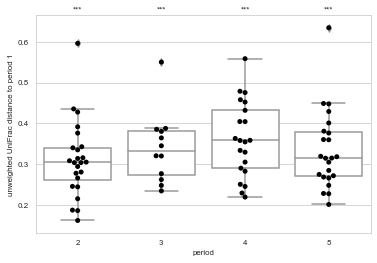

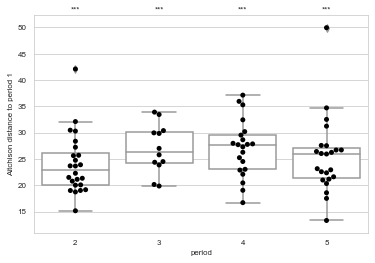

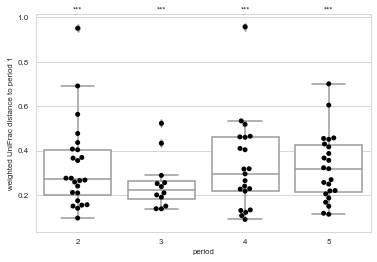

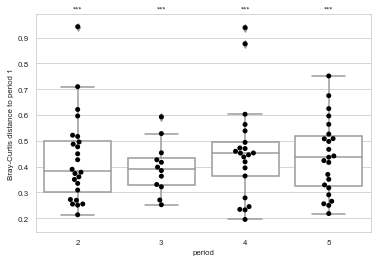

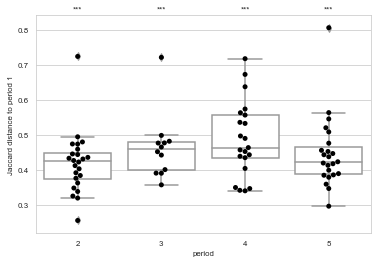

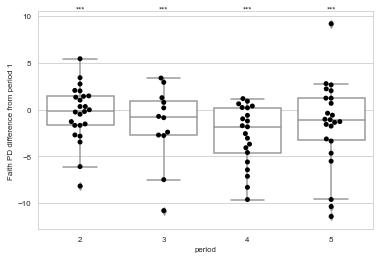

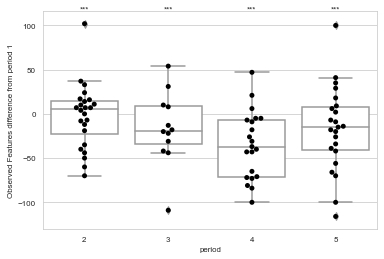

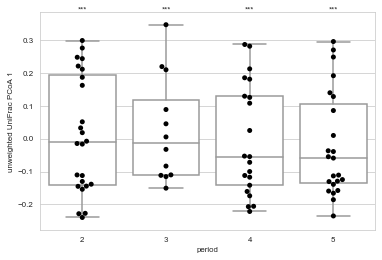

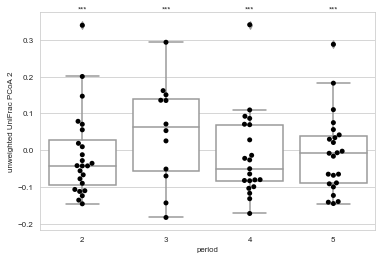

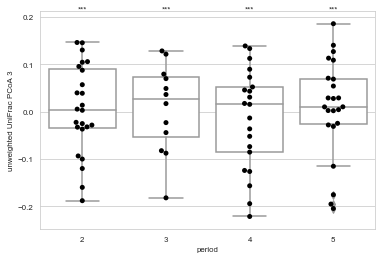

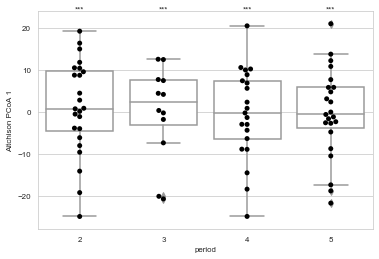

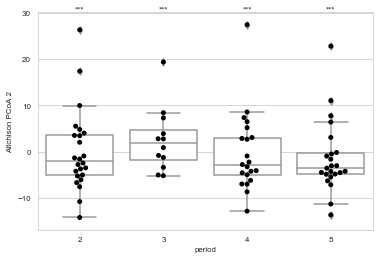

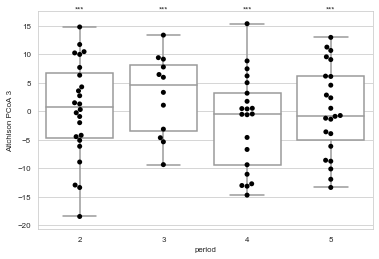

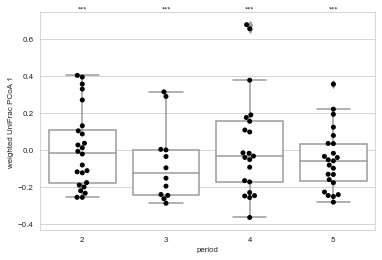

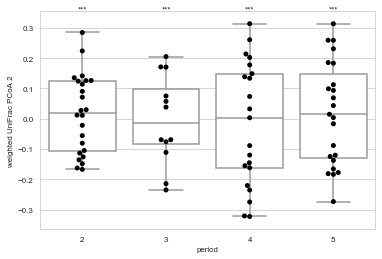

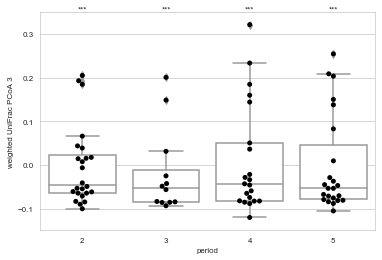

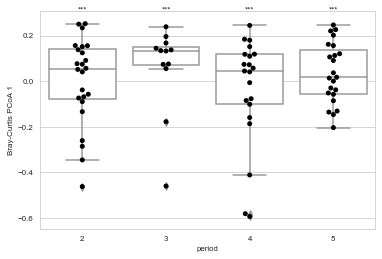

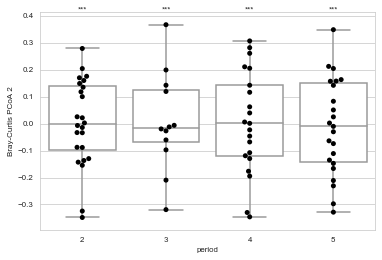

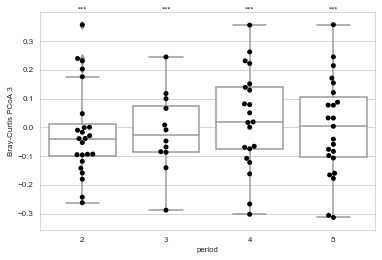

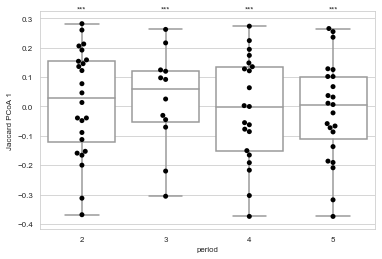

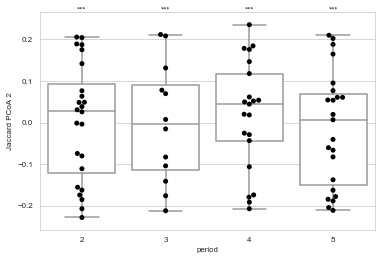

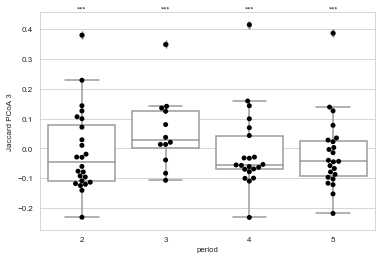

In [11]:
for e in distance_columns + alpha_columns + pcoa_columns:
    output_base_filepath = '%s-%s' % (project, e.replace(' ', '-'))
    output_figure_filepath = os.path.join(output_dir, '%s.pdf' % output_base_filepath)
    output_table_filepath = os.path.join(output_dir, '%s.csv' % output_base_filepath)
    plot_week_data_with_stats(data, metric=e, time_column=time_column, reference_time=reference_week, 
                              output_figure_filepath=output_figure_filepath, 
                              output_table_filepath=output_table_filepath)